##Fajri Yanti



>M03 - Time Series LSTM Project




In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from pandas.plotting import register_matplotlib_converters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [25]:
df = pd.read_csv('london.csv',
                  parse_dates=['timestamp'],
                  index_col='timestamp')
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [26]:
df.shape

(17414, 9)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [28]:
df['hour'] = df.index.hour
df['day_month'] = df.index.day
df['day_week'] = df.index.dayofweek
df['month'] = df.index.month

In [29]:
data_train= int(len(df) * .7)
data_test = len(df) - data_train
train, test = df.iloc[0:data_train], df.iloc[data_train:len(df)]
print(len(train), len(test))

12189 5225


In [ ]:
columns = ['t1', 't2', 'hum', 'wind_speed']
transformer = RobustScaler()
transformer = transformer.fit(train[columns].to_numpy())
train.loc[:, columns] = transformer.transform(
  train[columns].to_numpy()
)
test.loc[:, columns] = transformer.transform(
  test[columns].to_numpy()
)

In [ ]:
cnt_transformer = RobustScaler()
cnt_transformer = cnt_transformer.fit(train[['cnt']])
train['cnt'] = cnt_transformer.transform(train[['cnt']])
test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [32]:
def ds_new(X, y, time_steps=1):
    X1, y1 = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        X1.append(v)
        y1.append(y.iloc[i + time_steps])
    return np.array(X1), np.array(y1)

In [33]:
time_steps = 10

X_train, y_train = ds_new(train, train.cnt, time_steps)
X_test, y_test = ds_new(test, test.cnt, time_steps)
print(X_train.shape, y_train.shape)

(12179, 10, 13) (12179,)


In [34]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])



In [35]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/20
305/305 [==============================] - 6s 9ms/step - loss: 0.4458 - mean_absolute_error: 0.4919 - val_loss: 0.2766 - val_mean_absolute_error: 0.3354
Epoch 2/20
305/305 [==============================] - 2s 7ms/step - loss: 0.1297 - mean_absolute_error: 0.2629 - val_loss: 0.0839 - val_mean_absolute_error: 0.1990
Epoch 3/20
305/305 [==============================] - 2s 7ms/step - loss: 0.0735 - mean_absolute_error: 0.1973 - val_loss: 0.0803 - val_mean_absolute_error: 0.1964
Epoch 4/20
305/305 [==============================] - 2s 7ms/step - loss: 0.0540 - mean_absolute_error: 0.1647 - val_loss: 0.0487 - val_mean_absolute_error: 0.1411
Epoch 5/20
305/305 [==============================] - 3s 11ms/step - loss: 0.0454 - mean_absolute_error: 0.1521 - val_loss: 0.0563 - val_mean_absolute_error: 0.1433
Epoch 6/20
305/305 [==============================] - 2s 7ms/step - loss: 0.0396 - mean_absolute_error: 0.1386 - val_loss: 0.0315 - val_mean_absolute_error: 0.1157
Epoch 7/20
305/

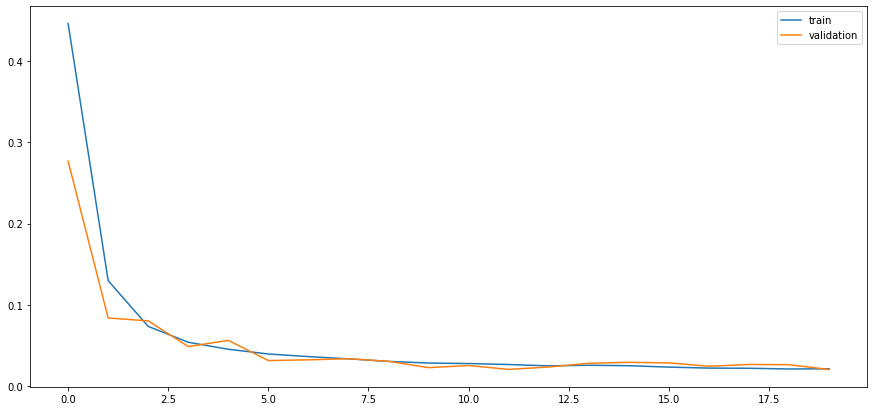

In [36]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [37]:
y_predict = model.predict(X_test)

In [38]:
y_train_reshape = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_reshape = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_predict_reshape = cnt_transformer.inverse_transform(y_predict)

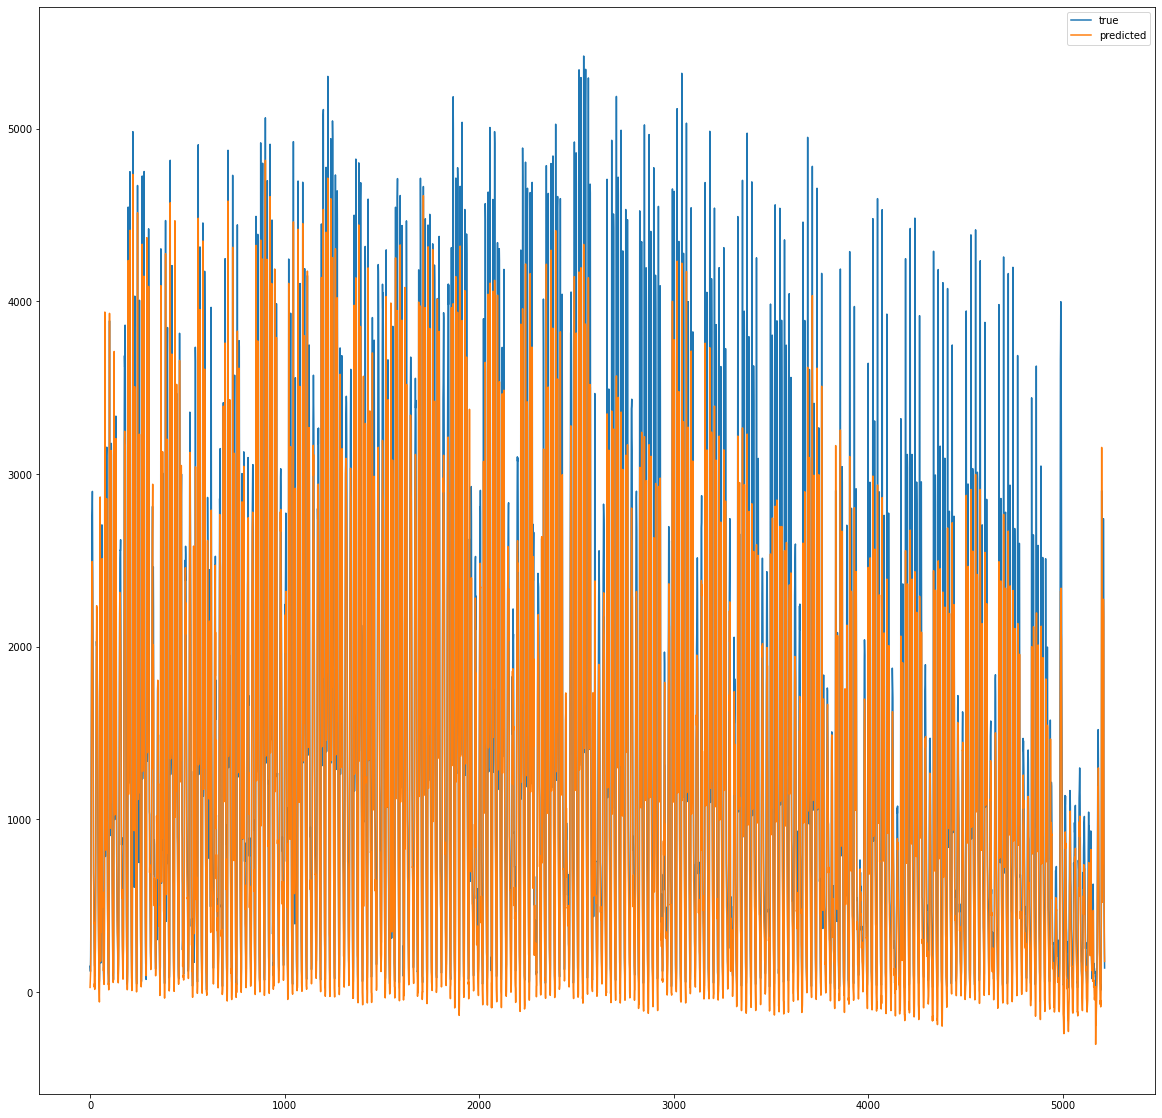

In [39]:
plt.figure(figsize=(20, 20))
plt.plot(y_test_reshape.flatten(), label='true')
plt.plot(y_predict_reshape.flatten(), label='predicted')
plt.legend()